<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesora: Maria Paz Raveau</em><br>
    <em>Asignatura: Procesamiento de Lenguaje Natural</em><br>

</div>

# **Tarea 2**

*Fecha de Entrega: Domingo 03, Agosto 2025.*

**Nombre Estudiante**: Victor Saldivia Vera

### **1. Intrucciones y Enunciado**

**Comparando topic modeling y clustering**

1. Los modelos LDA que ejecutamos en clases usaron una matriz DTM de tokens, esto
es, palabras solas. Es posible que la interpretación de los tópicos mejore al incorporar bigramas. Lo
primero que harás entonces es ejecutar un modelo LDA incorporando bigramas. Puedes ayudarte
de este link https://radimrehurek.com/gensim_3.8.3/auto_examples/tutorials/run_lda.html. 
(aunque no tienes necesariamente que hacerlo así). Entonces: 
    1. Usaremos un subset de la base de datos “El Chile que Queremos” El subset está disponible
en Canvas.
    2. Añadir bigramas al corpus.
    3. Ejecutar diagnóstico de tópicos y escoger un número de tópicos para el modelo. Justificar.
    4. Ejecutar LDA con el número de tópicos escogidos y etiquetar los tópicos, justificando en no
más de tres líneas, la etiqueta propuesta.
2. Los modelos LDA a menudo se usan para hacer clustering. A diferencia de otros
métodos de machine learning, LDA es un método pensado para trabajar con textos. Pero uno
perfectamente podría hacer clustering con otras técnicas (como Kmeans) a partir de la misma matriz
DTM que alimenta un modelo LDA. Se le pide, entonces, que pruebe con Kmeans sobre la matriz
DTM y compare los resultados con LDA. ¿Es el número óptimo de cluster el mismo que el número
óptimo de tópicos? ¿Qué partición hace más sentido?


### **2. Descripción de la Data**

Carga y primeras exploraciones del DataFrame original.  
- Columnas disponibles: 1
- Tamaño del dataset: 10276 registros  
- Conteo de nulos en las columnas de texto: 0


**Información Adicional:** Para ver en detalle la implementación completa de la tarea visitar el repositorio en Github.


**Repositorio GitHub de la Tarea**
- Tarea 2: https://github.com/Vikktor93/tarea2-NLP.git

### **3. Setup e Imports**


Importación de librerías necesarias:
- **pandas**: carga, limpieza y manipulación de DataFrame
- **numpy**: operaciones numéricas y arreglos
- **re**: expresiones regulares para normalización y limpieza de texto 
- **gensim**:  
  - `simple_preprocess`, `Phrases`, `Phraser` para tokenización y construcción de bigramas  
  - `corpora.Dictionary`, `LdaModel`, `CoherenceModel` para modelado LDA y diagnóstico de coherencia  
- **scikit-learn**:  
  - `CountVectorizer` para generar la matriz DTM (unigramas + bigramas) 
  - `KMeans` y `silhouette_score` para clustering y evaluación de particiones  
- **matplotlib**: creación de gráficos  


In [63]:
import os
import pandas as pd
import numpy as np
import re
from pprint import pprint

import gensim
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

*Nota: Se estableció `KMP_DUPLICATE_LIB_OK=TRUE` para evitar conflicto de múltiples runtimes OpenMP en Windows. Es un workaround temporal *(solución temporal)*.*

In [64]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### **4. Carga y Exploración Inicial**

In [65]:
with open('data/raw/ecqq.csv', encoding='utf-8') as f:
    lines = [l.rstrip('\n') for l in f]

# Si la primera línea es el nombre de la columna:
col_name, *data = lines

df = pd.DataFrame({col_name: data})

In [67]:
print(f"Dimensión: {df.shape}")
print("Número de registros:", len(df))
df.sample(5)

Dimensión: (10276, 1)
Número de registros: 10276


,\tP2_1_B
9463,ya que se encuentran amarrados a empresas priv...
5239,"mejorar distribución de recursos."""
5839,• costo de los medicamentos
9026,"3981\t""-muchas deficiencias en salud pública."
37,"23\t""- no existe el respeto hacia las personas."


### **5. Preprocesamiento de Texto y Bigramas**

#### **5.1 Normalizar y Tokenizar**

In [69]:
def normalize(text):
    t = text.lower()                         # convertir a minúsculas  
    t = re.sub(r'\s+', ' ', t)               # reemplazar uno o más espacios/tabs/saltos por un solo espacio
    t = re.sub(r"[^a-záéíóúñ ]", " ", t)     # eliminar todo lo que no sea letra (incluye ñ y vocales acentuadas) o espacio
    return t.strip()                         # eliminar espacios al inicio y al final

# Aplicar normalización
df['text_norm'] = df[col_name].apply(normalize)

#### **5.2 Guardar Dataframe Limpio**

In [70]:
os.makedirs('data/processed', exist_ok=True)
df_limpio = df[[col_name, 'text_norm']].copy()
output_path = 'data/processed/ecqq_limpio.csv'
df_limpio.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"DataFrame limpio guardado en: {output_path} (filas: {len(df_limpio)})\n")

DataFrame limpio guardado en: data/processed/ecqq_limpio.csv (filas: 10276)



In [72]:
# Muestra de 5 registros aleatorios del DataFrame limpio
df_limpio.sample(5)

,\tP2_1_B,text_norm
7303,3263\tlos participantes expresan que la justic...,los participantes expresan que la justicia en ...
435,costo y calidad de salud.,costo y calidad de salud
6058,subsidios para gama más amplia de remedios de ...,subsidios para gama más amplia de remedios de ...
352,"177\t""toda persona pensionada sin distinción d...",toda persona pensionada sin distinción debe pa...
4464,2032\tnos devuelvan las confianzas de poder ac...,nos devuelvan las confianzas de poder acceder ...


#### **5.3 Tokenización con Gensim**

In [73]:
data_tokens = [simple_preprocess(doc, deacc=True) for doc in df['text_norm']]
print("Ejemplo tokens (sin bigramas):", data_tokens[0][:15], "\n")

Ejemplo tokens (sin bigramas): ['se', 'necesitan', 'pensiones', 'dignas', 'los', 'adultos', 'mayores', 'ya', 'que', 'no', 'alcanza', 'el', 'costo', 'de', 'vida'] 



#### **5.4 Entrenar modelo de bigramas**

In [74]:
bigram = Phrases(data_tokens, min_count=5, threshold=100)  # ajustar según corpus
bigram_mod = Phraser(bigram)

#### **5.5 Aplicar bigramas al corpus tokenizado**

In [77]:
data_tokens_bi = [bigram_mod[doc] for doc in data_tokens]
print("Ejemplo tokens con bigramas:", data_tokens_bi[0][:10])

Ejemplo tokens con bigramas: ['se', 'necesitan', 'pensiones', 'dignas', 'los', 'adultos_mayores', 'ya', 'que', 'no', 'alcanza']


### **6. Diccionario y Corpus (DTM)**
A continuación se utiliza la librería `gensim` para convertir el conjunto de documentos tokenizados en una representación numérica (Bag of Words).

#### **6.1 Diccionario**
Se crea un diccionario que asigna un ID único a cada palabra encontrada en `data_tokens_bi`.

Además se filtra palabras poco y muy frecuentes:
- `no_below=5`: Elimina palabras que aparecen en menos de 5 documentos
- `no_above=0.5`: Elimina palabras que aparecen en más del 50% de los documentos
- `keep_n=10000`: Conserva solo las 10000 palabras más frecuentes

In [78]:
# Crear diccionario y corpus
dictionary = corpora.Dictionary(data_tokens_bi)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=10000) # Filtrar palabras poco frecuentes y muy frecuentes
print("Tamaño vocabulario:", len(dictionary))

Tamaño vocabulario: 1702


#### **6.2 Creación del Corpus (Bag of Words)**

- Se convierte cada documento en un vector de conteo de palabras (Bag of Words)
- Cada documento se representa como una lista de tuplas `(id_palabra, frecuencia)`

In [80]:
corpus = [dictionary.doc2bow(text) for text in data_tokens_bi]
print("Muestra de las primeras 10 entradas del vector BOW para el 1° Documento:", corpus[0][:10])

Muestra de las primeras 10 entradas del vector BOW para el 1° Documento: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


### **7. Diagnóstico de Número de Temas (Coherence)**

k=2 → coherence=0.4941
k=3 → coherence=0.4810
k=4 → coherence=0.5039
k=5 → coherence=0.4966
k=6 → coherence=0.4993
k=7 → coherence=0.4590
k=8 → coherence=0.4717
k=9 → coherence=0.4667
k=10 → coherence=0.4462


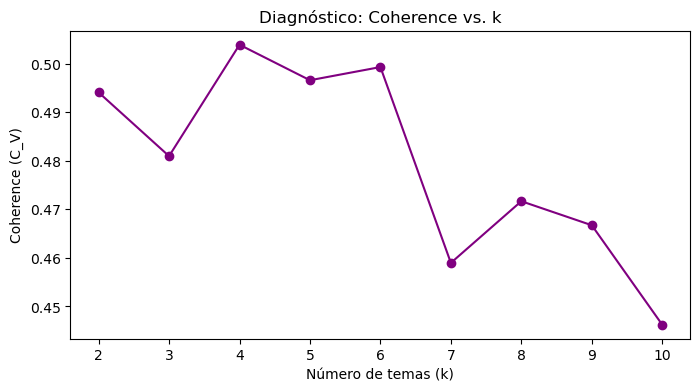

In [83]:
coherence_scores = []
model_list = []
K = range(2, 11)

for k in K:
    lda = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=42,
        passes=10,
        alpha='auto',
        per_word_topics=False
    )
    cm = CoherenceModel(
        model=lda,
        texts=data_tokens_bi,
        dictionary=dictionary,
        coherence='c_v'
    )
    score = cm.get_coherence()
    coherence_scores.append(score)
    model_list.append(lda)
    print(f"k={k} → coherence={score:.4f}")

# Grafico
plt.figure(figsize=(8,4))
plt.plot(K, coherence_scores, marker='o', color='purple')
plt.xlabel('Número de temas (k)')
plt.ylabel('Coherence (C_V)')
plt.title('Diagnóstico: Coherence vs. k')
plt.show()


Según el *Análisis de Coherencia para Selección de Número de Temas (k)* realizado, los valores de coherencia para cada número de temas (k) fueron:

| k  | Coherencia (C_V) |
|----|------------------|
| 2  | 0.4941           |
| 3  | 0.4810           |
| **4**  | **0.5039**       |
| 5  | 0.4966           |
| 6  | 0.4993           |
| 7  | 0.4590           |
| 8  | 0.4717           |
| 9  | 0.4667           |
| 10 | 0.4462           |

**Interpretación**

1. **Punto óptimo**: 
   - El valor máximo de coherencia (0.5039) se alcanza con **k=4 temas**
   - Este es el punto donde los temas generados tienen mayor coherencia semántica interna

2. **Patrón observado**:
   - Decrecimiento consistente para k > 4
   - Comportamiento relativamente estable entre k=5 y k=6

3. **Recomendación**:
   - **Lo mejor es seleccionar k=4** como número óptimo de temas
   - Los modelos con k>4 muestran:
     - Menor coherencia promedio
     - Posible sobre-división de temas
     - Mayor complejidad sin ganancia interpretativa